In [1]:
!pip install kaggle

In [2]:
!pip install shap

In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od

In [5]:
import os
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
import cv2
import numpy as np
import pandas as pd

In [6]:
od.download("https://www.kaggle.com/competitions/fake-news-pair-classification-challenge/data")

Skipping, found downloaded files in "./fake-news-pair-classification-challenge" (use force=True to force download)


In [7]:
train = pd.read_csv('/content/fake-news-pair-classification-challenge/train.csv',index_col='id')
test = pd.read_csv('/content/fake-news-pair-classification-challenge/test.csv',index_col='id')

In [8]:
train.columns

Index(['tid1', 'tid2', 'title1_zh', 'title2_zh', 'title1_en', 'title2_en',
       'label'],
      dtype='object')

In [9]:
train['tid1'].value_counts()

113886    755
45314     466
153067    421
82910     381
19028     371
         ... 
111043      1
26729       1
89454       1
14932       1
167563      1
Name: tid1, Length: 69170, dtype: int64

In [10]:
train['label'].value_counts()

unrelated    219313
agreed        92973
disagreed      8266
Name: label, dtype: int64

In [11]:
train['title1_en'].value_counts()

Someone from the People's Hospital of Cengxi City jumped to his death.                                                         755
An old rumor spread by the old rumour of "multi-person infected with SK 5 virus"                                               466
Men in the wrong tent, "unspeakable things" to be beaten?                                                                      421
Nanking Suing Fans Hung Suicides                                                                                               381
He's a 90-year-old boy who bought BMW 3 years after he graduated, but few of his friends would ever look at him.               371
                                                                                                                              ... 
Xuan Xuan to Gutian: Let's have children, netizen: together                                                                      1
It's good to grow these plants indoors! Purify the air, absorb the harmful substanc

In [12]:
train['title2_en'].value_counts()

The world's first talking dog shocked 6 billion people.                                                                                          66
Song Xiao Bo returned to class, Ma Yun sat down to listen carefully.                                                                             48
Big Brother Zhu Zhu Wen is full of women! This time not only Mandarin but also another beautiful woman.                                          42
Liu Qiangdong threatened to dump Ma Yun three streets, Ma, I have never put King Dongfang in the eye.                                            31
Mr Ma's speech in 2018 will call for a total ban on rural construction. What about migrant workers?                                              24
                                                                                                                                                 ..
The central government has issued 2.56 billion farmers in the countryside, and the peasants who have received su

In [13]:
cols = ['title1_en', 'title2_en', 'label']
train = train.loc[:, cols]
train.head(3)

,title1_en,title2_en,label
id,,,
0,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
1,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated


In [14]:
import jieba.posseg as pseg
import os
import keras

In [15]:
text = 'What are you doing here?'
words = pseg.cut(text)
[word for word in words]

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.952 seconds.
Prefix dict has been built successfully.


[pair('What', 'eng'),
 pair(' ', 'x'),
 pair('are', 'eng'),
 pair(' ', 'x'),
 pair('you', 'eng'),
 pair(' ', 'x'),
 pair('doing', 'eng'),
 pair(' ', 'x'),
 pair('here', 'eng'),
 pair('?', 'x')]

In [16]:
def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([
        word for word, flag in words if flag != 'x'])

In [17]:
train.title2_en.fillna('UNKNOWN', inplace=True)
train.isna().any()

title1_en    False
title2_en    False
label        False
dtype: bool

In [18]:
def process(data):
    res = data.apply(jieba_tokenizer)
    return res


def check_merge_idx(data, res):
    assert((data.index == res.index).all(), 'Something error when merge data')

def parallelize(data, func):
    from multiprocessing import cpu_count, Pool
    cores = partitions = cpu_count()
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    res = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    check_merge_idx(data, res)
    return res

<ipython-input-18-2085024a8821>:7: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert((data.index == res.index).all(), 'Something error when merge data')


In [19]:
np.all(train.index == train.title1_en.index)

True

In [20]:
print("start to training")
train['title1_tokenized'] = parallelize(train.loc[:, 'title1_en'], process)
train['title2_tokenized'] = parallelize(train.loc[:, 'title2_en'], process)
train.to_csv('tokenized_train.csv',index=True)

start to training


In [21]:
train.loc[:, ["title1_en", "title1_tokenized"]].head(10)

,title1_en,title1_tokenized
id,,
0,There are two new old-age insurance benefits f...,There are two new old age insurance benefits f...
3,"""If you do not come to Shenzhen, sooner or lat...",If you do not come to Shenzhen sooner or later...
1,"""If you do not come to Shenzhen, sooner or lat...",If you do not come to Shenzhen sooner or later...
2,"""If you do not come to Shenzhen, sooner or lat...",If you do not come to Shenzhen sooner or later...
9,"""How to discriminate oil from gutter oil by me...",How to discriminate oil from gutter oil by mea...
4,"""If you do not come to Shenzhen, sooner or lat...",If you do not come to Shenzhen sooner or later...
6,"""if you eat durian, you will kill yourself if ...",if you eat durian you will kill yourself if yo...
5,"""If you do not come to Shenzhen, sooner or lat...",If you do not come to Shenzhen sooner or later...
7,"""Frog frog? It's a fertility test! Let's play""...",Frog frog It fertility test Let play Jewel


In [22]:
train.loc[:, ["title2_en", "title2_tokenized"]].head(10)

,title2_en,title2_tokenized
id,,
0,"Police disprove ""bird's nest congress each per...",Police disprove bird nest congress each person...
3,Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,Shenzhen GDP outstrips Hong Kong Shenzhen Stat...
1,The GDP overtopped Hong Kong? Shenzhen clarifi...,The GDP overtopped Hong Kong Shenzhen clarifie...
2,Shenzhen's GDP topped Hong Kong last year? She...,Shenzhen GDP topped Hong Kong last year Shenzh...
9,It took 30 years of cooking oil to know that o...,It took 30 years of cooking oil to know that o...
4,Shenzhen's GDP overtakes Hong Kong? Bureau of ...,Shenzhen GDP overtakes Hong Kong Bureau of Sta...
6,"Durian can't eat with anything, it's the same ...",Durian can eat with anything it the same as co...
5,Shenzhen's GDP outpaces Hong Kong? Defending R...,Shenzhen GDP outpaces Hong Kong Defending Rumo...
7,"A store in xianning contains ""cotton""? A multi...",store in xianning contains cotton multi agency...


In [23]:
train.fillna('UNKNOWN', inplace=True)

In [24]:
MAX_NUM_WORDS = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)

In [25]:
corpus_x1 = train.title1_tokenized
corpus_x2 = train.title2_tokenized
corpus = pd.concat([
    corpus_x1, corpus_x2])
corpus.shape

(641104,)

In [26]:
pd.DataFrame(corpus.iloc[:5],columns=['title'])

,title
id,
0,There are two new old age insurance benefits f...
3,If you do not come to Shenzhen sooner or later...
1,If you do not come to Shenzhen sooner or later...
2,If you do not come to Shenzhen sooner or later...
9,How to discriminate oil from gutter oil by mea...


In [27]:
corpus.isna().any()

False

In [28]:
tokenizer.fit_on_texts(corpus)
x1_train = tokenizer.texts_to_sequences(corpus_x1)
x2_train = tokenizer.texts_to_sequences(corpus_x2)

In [29]:
len(x1_train)

320552

In [30]:
x1_train[:1]

[[65, 16, 57, 28, 23, 255, 569, 808, 11, 23, 29, 6, 88, 446, 19, 8, 428, 175]]

In [31]:
for seq in x1_train[:1]:
    print([tokenizer.index_word[idx] for idx in seq])

['there', 'are', 'two', 'new', 'old', 'age', 'insurance', 'benefits', 'for', 'old', 'people', 'in', 'rural', 'areas', 'have', 'you', 'got', 'them']


In [32]:
MAX_SEQUENCE_LENGTH = 20
x1_train = keras.preprocessing.sequence.pad_sequences(x1_train, maxlen=MAX_SEQUENCE_LENGTH)

x2_train = keras.preprocessing.sequence.pad_sequences(x2_train, maxlen=MAX_SEQUENCE_LENGTH)

In [33]:
x1_train[0]

array([  0,   0,  65,  16,  57,  28,  23, 255, 569, 808,  11,  23,  29,
         6,  88, 446,  19,   8, 428, 175], dtype=int32)

In [34]:
for seq in x1_train + x2_train:
    assert len(seq) == 20

In [35]:
train.label[:5]

id
0    unrelated
3    unrelated
1    unrelated
2    unrelated
9       agreed
Name: label, dtype: object

In [36]:
import numpy as np 

label_to_index = {
    'unrelated': 0, 
    'agreed': 1, 
    'disagreed': 2
}

y_train = train.label.apply(
    lambda x: label_to_index[x])

y_train = np.asarray(y_train) \
            .astype('float32')

y_train[:5]

array([0., 0., 0., 0., 1.], dtype=float32)

In [37]:
x1_train[:5]

array([[   0,    0,   65,   16,   57,   28,   23,  255,  569,  808,   11,
          23,   29,    6,   88,  446,   19,    8,  428,  175],
       [ 141,  833,   38,  196,   13,   90,  199,    6,  386,   74,   78,
          35,  746,  586, 5402, 2834,   13, 5161,  523,  620],
       [ 141,  833,   38,  196,   13,   90,  199,    6,  386,   74,   78,
          35,  746,  586, 5402, 2834,   13, 5161,  523,  620],
       [ 141,  833,   38,  196,   13,   90,  199,    6,  386,   74,   78,
          35,  746,  586, 5402, 2834,   13, 5161,  523,  620],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   33,    2,
        4287,  375,   45, 3768,  375,   32, 2529,    3,  406]],
      dtype=int32)

In [38]:
train.label[:5]

id
0    unrelated
3    unrelated
1    unrelated
2    unrelated
9       agreed
Name: label, dtype: object

In [39]:
from keras.utils import np_utils

In [40]:
y_train = keras.utils.np_utils.to_categorical(y_train)

y_train[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [41]:
from sklearn.model_selection import train_test_split
train_set, test_set,train_set1,test_set1,target_train,target_test = train_test_split(x1_train, x2_train, y_train, test_size=0.1,random_state=42)
print(target_train.shape,target_test.shape)
print(train_set1.shape)
print(test_set1.shape)
print(test_set.shape)
print(train_set.shape)

(288496, 3) (32056, 3)
(288496, 20)
(32056, 20)
(32056, 20)
(288496, 20)


In [42]:
from sklearn.model_selection import train_test_split
train_set, test_set,train_set1,test_set1,target_train,target_test = train_test_split(x1_train, x2_train, y_train, test_size=0.1,random_state=42)
print(target_train.shape,target_test.shape)
print(train_set1.shape)
print(test_set1.shape)
print(test_set.shape)
print(train_set.shape)

(288496, 3) (32056, 3)
(288496, 20)
(32056, 20)
(32056, 20)
(288496, 20)


In [43]:

from keras import Input
from keras.layers import Embedding,LSTM, concatenate, Dense
from keras.models import Model

tp = Input(shape=(20, ))
bp = Input(shape=(20, ))

e__m = Embedding(10000, 256)
t_e = e__m(tp)
b_e= e__m(bp)

ls = LSTM(128)
t_o= ls(t_e)
b_o = ls(b_e)

mer = concatenate([t_o, b_o], axis=-1)

d =  Dense(units=3, activation='softmax')
out = d(mer)

model = Model(inputs=[tp, bp], outputs=out)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 256)      2560000     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 128)          197120      ['embedding[0][0]',          

In [47]:
from tensorflow.python.keras.layers import Input, Dense, Dropout,Conv1D,MaxPooling1D,Activation,Flatten,AveragePooling1D,GlobalMaxPooling1D,ZeroPadding1D

In [50]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
input_A = keras.layers.Input(shape=[104,1])
y=Conv1D(64, (3),data_format='channels_last',activation='relu',padding='valid')(input_A)
y=Conv1D(64, (3),data_format='channels_last',activation='relu',padding='valid')(y)
y=MaxPooling1D((2),data_format='channels_last')(y)

y=Conv1D(128, (3),data_format='channels_last',activation='relu',padding='same')(y)
y=Conv1D(128, (3),data_format='channels_last',activation='relu',padding='same')(y)
y=MaxPooling1D((2),data_format='channels_last')(y)

y=Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y)
y=Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y)
y=MaxPooling1D((2),data_format='channels_last')(y)

y=Conv1D(512, (3),data_format='channels_last',activation='relu',padding='same')(y)
y=Conv1D(512, (3),data_format='channels_last',activation='relu',padding='same')(y)
y=Conv1D(512, (3),data_format='channels_last',activation='relu',padding='same')(y)
y=MaxPooling1D((2),data_format='channels_last')(y)

y=Conv1D(512, (3),data_format='channels_last',activation='relu',padding='same')(y)
y=Conv1D(512, (3),data_format='channels_last',activation='relu',padding='same')(y)
y=Conv1D(512, (3),data_format='channels_last',activation='relu',padding='same')(y)
y=MaxPooling1D((2),data_format='channels_last')(y)
y=Dense(4096,activation='relu')(y)
y =Dropout(0.5)(y) 
y=Dense(4096,activation='relu')(y)
y =Dropout(0.5)(y)
y=Dense(1000,activation='relu')(y)
y =Dropout(0.5)(y) 
out=Dense(3,activation='softmax')(y)
vgg16= keras.models.Model(inputs=[input_A], outputs=[out])

In [53]:
input_A = keras.layers.Input(shape=[44,1])
y = Conv1D(64, (7),data_format='channels_last',activation='relu',padding='same',strides=2)(input_A)
y1 = MaxPooling1D((2),data_format='channels_last',padding='same')(y)
y2 = Conv1D(64, (3),data_format='channels_last',activation='relu',padding='same')(y1)
y2 = Conv1D(64, (3),data_format='channels_last',activation='relu',padding='same')(y2)
y3 = y2+y1
y4 = Conv1D(64, (3),data_format='channels_last',activation='relu',padding='same')(y3)
y4 = Conv1D(64, (3),data_format='channels_last',activation='relu',padding='same')(y4)
y5 = y3+y4
y6 = Conv1D(64, (3),data_format='channels_last',activation='relu',padding='same')(y5)
y6 = Conv1D(64, (3),data_format='channels_last',activation='relu',padding='same')(y6)
y7 = y6+y5
#128
y8 = Conv1D(128, (3),data_format='channels_last',activation='relu',padding='same',strides=2)(y7)
y8 = Conv1D(128, (3),data_format='channels_last',activation='relu',padding='same')(y8)
y9 = Conv1D(128, (3),data_format='channels_last',activation='relu',padding='same')(y8)
y9 = Conv1D(128, (3),data_format='channels_last',activation='relu',padding='same')(y9)
y10 = y8+y9
y11 = Conv1D(128, (3),data_format='channels_last',activation='relu',padding='same')(y10)
y11 = Conv1D(128, (3),data_format='channels_last',activation='relu',padding='same')(y11)
y12 = y10+y11
y13 = Conv1D(128, (3),data_format='channels_last',activation='relu',padding='same')(y12)
y13 = Conv1D(128, (3),data_format='channels_last',activation='relu',padding='same')(y13)
y14 = y13+y12
#256
y15 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same',strides=2)(y14)
y15 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y15)
y16 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y15)
y16 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y16)
y17 = y16+y15
y18 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y17)
y18 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y18)
y19 = y17+y18
y20 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y19)
y20 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y20)
y21 = y19+y20
y22 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y21)
y22 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y22)
y23 = y21+y22
y24 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y23)
y24 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y24)
y25 = y23+y24
y26 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y25)
y26 = Conv1D(256, (3),data_format='channels_last',activation='relu',padding='same')(y26)
y27 = y25+y26
#512
y28 = Conv1D(512, (3),data_format='channels_last',activation='relu',padding='same',strides=2)(y27)
y28 = Conv1D(512, (3),data_format='channels_last',activation='relu',padding='same')(y28)
y29 = Conv1D(512, (3),data_format='channels_last',activation='relu',padding='same')(y28)
y29 = Conv1D(512, (3),data_format='channels_last',activation='relu',padding='same')(y29)
y30 = y29 +y28
y31 = Conv1D(512, (3),data_format='channels_last',activation='relu',padding='same')(y30)
y31 = Conv1D(512, (3),data_format='channels_last',activation='relu',padding='same')(y31)
y32 = y30+y31  
#avrage_pooling
y33 =  AveragePooling1D((2),data_format='channels_last',padding='same')(y32)
out=Dense(3,activation='softmax')(y33)
Resnet50= keras.models.Model(inputs=[input_A], outputs=[out])


In [44]:
from tensorflow.keras.optimizers import Adam
learn = 1e-3
opt = Adam(lr=learn, decay=0.01)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [46]:


history = model.fit(
    x=[x1_train, x2_train], 
    y=y_train,
    batch_size=1024,
    epochs=50,
    validation_data=(
        [test_set, test_set1], 
        target_test
    ),
    shuffle=True
)

Epoch 1/50
314/314 [==============================] - 8s 24ms/step - loss: 0.5029 - accuracy: 0.7656 - val_loss: 0.4984 - val_accuracy: 0.7700
Epoch 2/50
314/314 [==============================] - 6s 20ms/step - loss: 0.4988 - accuracy: 0.7680 - val_loss: 0.4944 - val_accuracy: 0.7721
Epoch 3/50
314/314 [==============================] - 6s 19ms/step - loss: 0.4948 - accuracy: 0.7702 - val_loss: 0.4902 - val_accuracy: 0.7754
Epoch 4/50
314/314 [==============================] - 6s 19ms/step - loss: 0.4905 - accuracy: 0.7728 - val_loss: 0.4857 - val_accuracy: 0.7766
Epoch 5/50
314/314 [==============================] - 6s 19ms/step - loss: 0.4860 - accuracy: 0.7752 - val_loss: 0.4812 - val_accuracy: 0.7785
Epoch 6/50
314/314 [==============================] - 6s 19ms/step - loss: 0.4814 - accuracy: 0.7782 - val_loss: 0.4760 - val_accuracy: 0.7821
Epoch 7/50
314/314 [==============================] - 6s 19ms/step - loss: 0.4764 - accuracy: 0.7809 - val_loss: 0.4709 - val_accuracy: 0.7845

In [54]:
y_val0 = []
for x in target_test:
  y_val0.append(np.argmax(x))
y_val0 = np.array(y_val0)

In [55]:
pred = model.predict([test_set, test_set1])
pred1 =[]
for x in pred:
  pred1.append(np.argmax(x))
pred1 = np.array(pred1)  

In [56]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_val0,  pred1, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.85      0.91      0.88     21935
     class 1       0.78      0.70      0.73      9296
     class 2       0.80      0.26      0.39       825

    accuracy                           0.83     32056
   macro avg       0.81      0.62      0.67     32056
weighted avg       0.83      0.83      0.83     32056



In [57]:
!pip install scikit-plot

In [58]:
import scikitplot as skplt
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


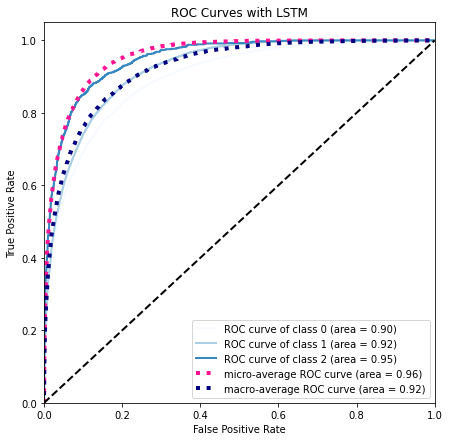

In [59]:
skplt.metrics.plot_roc_curve(y_val0,pred,title="ROC Curves with LSTM", cmap='Blues', figsize=[7,7])
plt.show()

In [60]:

from keras import Input
from keras.layers import Embedding,LSTM, concatenate, Dense,Conv1D,Flatten
from keras.models import Model

tp = Input(shape=(20, ))
bp = Input(shape=(20,) )

e__m = Embedding(10000, 256)
t_e = e__m(tp)
b_e= e__m(bp)

c = Conv1D(kernel_size=3,padding='same',filters=256,activation='relu')
t_o= c(t_e)
b_o = c(b_e)

mer = concatenate([t_o, b_o], axis=-1)
mer = Flatten()(mer)
d =  Dense(units=3, 
    activation='softmax')
out = d(mer)

model1 = Model(
    inputs=[tp, bp], 
    outputs=out)

model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 20, 256)      2560000     ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 256)      196864      ['embedding_1[0][0]',      

In [61]:
from tensorflow.keras.optimizers import Adam
lr = 3e-1
opt = Adam(lr=lr, decay=lr)
model1.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [62]:
hi = model1.fit(
    x=[x1_train, x2_train], 
    y=y_train,
    batch_size=2048,
    epochs=50,
    validation_data=(
        [test_set, test_set1], 
        target_test
    ))

Epoch 1/50
157/157 [==============================] - 14s 37ms/step - loss: 48.0464 - accuracy: 0.6752 - val_loss: 0.7147 - val_accuracy: 0.6852
Epoch 2/50
157/157 [==============================] - 5s 33ms/step - loss: 0.7169 - accuracy: 0.6854 - val_loss: 0.7129 - val_accuracy: 0.6852
Epoch 3/50
157/157 [==============================] - 5s 31ms/step - loss: 0.7133 - accuracy: 0.6855 - val_loss: 0.7124 - val_accuracy: 0.6851
Epoch 4/50
157/157 [==============================] - 5s 31ms/step - loss: 0.7124 - accuracy: 0.6856 - val_loss: 0.7122 - val_accuracy: 0.6853
Epoch 5/50
157/157 [==============================] - 5s 30ms/step - loss: 0.7120 - accuracy: 0.6856 - val_loss: 0.7121 - val_accuracy: 0.6853
Epoch 6/50
157/157 [==============================] - 5s 31ms/step - loss: 0.7118 - accuracy: 0.6856 - val_loss: 0.7120 - val_accuracy: 0.6853
Epoch 7/50
157/157 [==============================] - 5s 31ms/step - loss: 0.7117 - accuracy: 0.6856 - val_loss: 0.7119 - val_accuracy: 0.68

In [63]:
y_val0 = []
for x in target_test:
  y_val0.append(np.argmax(x))
y_val0 = np.array(y_val0)

In [64]:
pred = model.predict([test_set, test_set1])
pred1 =[]
for x in pred:
  pred1.append(np.argmax(x))
pred1 = np.array(pred1)  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


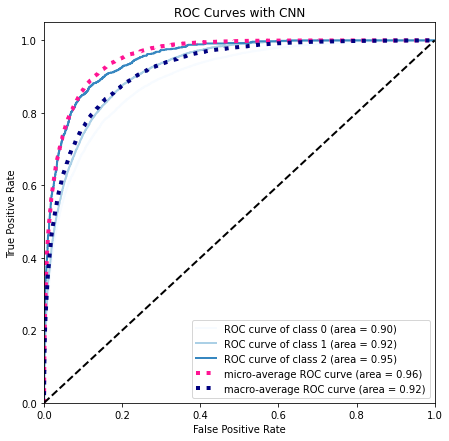

In [65]:
skplt.metrics.plot_roc_curve(y_val0,pred,title="ROC Curves with CNN", cmap='Blues', figsize=[7,7])
plt.show()

In [66]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_val0,  pred1, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.85      0.91      0.88     21935
     class 1       0.78      0.70      0.73      9296
     class 2       0.80      0.26      0.39       825

    accuracy                           0.83     32056
   macro avg       0.81      0.62      0.67     32056
weighted avg       0.83      0.83      0.83     32056

